In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when
spark = SparkSession.builder.appName("SamsungStockClean").getOrCreate()
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import setuptools._distutils as distutils
import sys
sys.modules['distutils'] = distutils
from matplotlib.lines import Line2D
from matplotlib import dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb
import math
import warnings
warnings.filterwarnings('ignore')
import itertools    
import logging
logging.getLogger("prophet.plot").disabled = True
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
from datetime import datetime, timedelta
from datetime import date

In [3]:
#Load data
ss = spark.read.csv("./Samsung Electronics Stock Historical Price.csv", header=True, inferSchema=True)
ss.printSchema()
ss.describe().show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1505|              1505|             1505|              1505|              1505|                1505|
|   mean|64154.617940199336| 64734.01993355482|63548.70431893688| 64108.90365448505| 59933.01363164452|1.6625267806644518E7|
| stddev|12269.830762688787|12321.091698838984|12176.81337181051|12227.346772831712|12894.680103072302|   87315

In [4]:
#Load KOSPI data
kospi = spark.read.csv("./KOSPI Data.csv", header=True, inferSchema=True)
kospi.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)



In [533]:
ss.dtypes

[('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'int')]

In [4]:
# Count missing values in each column
missing = {col_name: ss.filter(col(col_name).isNull()).count() for col_name in ss.columns}
print(missing)
# Because the data of the stock price is updated every day, there is no missing value in the data.

{'Date': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0, 'Volume': 0}


In [5]:
# Check for duplicate rows
duplicates = ss.groupBy(ss.columns).count().filter(col("count") > 1)
print("Number of duplicate rows:", duplicates.count())
duplicates.show()

Number of duplicate rows: 0
+----+----+----+---+-----+---------+------+-----+
|Date|Open|High|Low|Close|Adj Close|Volume|count|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



In [5]:
# Check if 'Open' or 'Close' is less than 'Low'
lower_than_low = ss.filter((col("Open") < col("Low")) | (col("Close") < col("Low")))
print("Số lần 'Open' hoặc 'Close' thấp hơn 'Low':", lower_than_low.count())
lower_than_low.show()
# Fix incorrect data: if 'Low' < 'Close', set 'Low' to 'Close'
ss_fixed = ss.withColumn("Low", when(col("Low") < col("Close"), col("Close")).otherwise(col("Low")))

ss_fixed.orderBy("Date").show(5)


Số lần 'Open' hoặc 'Close' thấp hơn 'Low': 1
+----------+-------+-------+-------+-------+-------------+--------+
|      Date|   Open|   High|    Low|  Close|    Adj Close|  Volume|
+----------+-------+-------+-------+-------+-------------+--------+
|2024-10-14|59500.0|61200.0|59400.0|59300.0|58898.3984375|20886249|
+----------+-------+-------+-------+-------+-------------+--------+

+----------+-------+-------+-------+-------+---------------+--------+
|      Date|   Open|   High|    Low|  Close|      Adj Close|  Volume|
+----------+-------+-------+-------+-------+---------------+--------+
|2019-01-02|39400.0|39400.0|38750.0|38750.0| 33061.84765625| 7847664|
|2019-01-03|38300.0|38550.0|37600.0|37600.0|32080.662109375|12471493|
|2019-01-04|37450.0|37600.0|37450.0|37450.0| 31952.66796875|14108958|
|2019-01-07|38000.0|38900.0|38750.0|38750.0| 33061.84765625|12748997|
|2019-01-08|38000.0|39200.0|38100.0|38100.0|32507.259765625|12756554|
+----------+-------+-------+-------+-------+----------

In [6]:
# Convert spark DataFrame to Pandas DataFrame
ss_pd = ss_fixed.toPandas()
kospi_pd = kospi.toPandas()

In [8]:
#Stop Spark session
spark.stop()

### **1. Data Analysis**

##### Candle chart of 200 days nearest


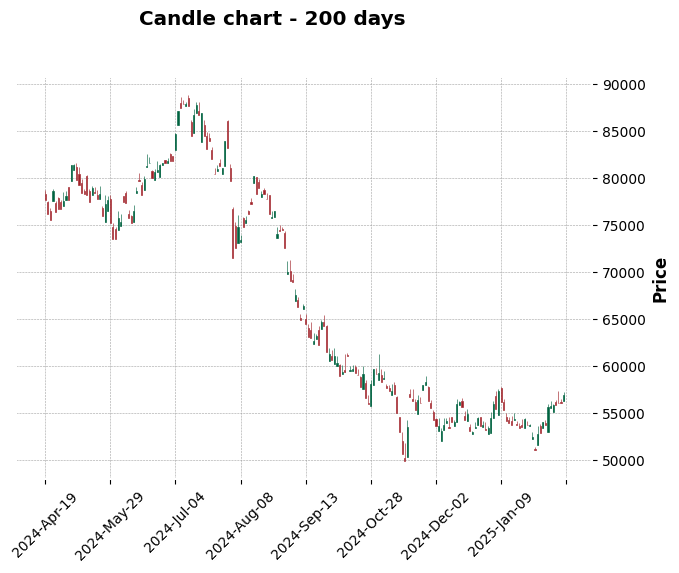

In [539]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_candle = ss_pd[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ss_candle.set_index('Date', inplace=True)

mpf.plot(ss_candle[-200:], type='candle', style='charles', title='Candle chart - 200 days')


##### Samsung versus KOSPI cumulative daily return

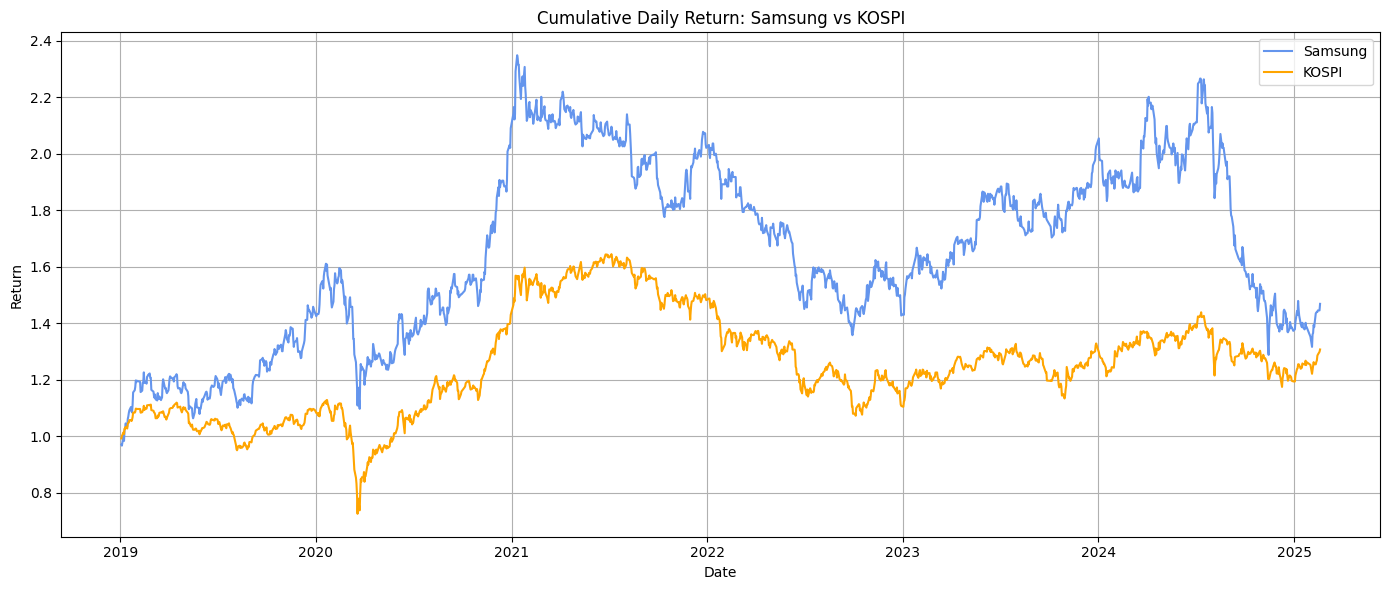

In [25]:
# Calculate daily returns 
ss_pd['Return'] = ss_pd['Close'].pct_change()
# kospi_pd['Price'] is already float, so no need to convert or replace commas
kospi_pd['Return'] = kospi_pd['Price'].pct_change()
# Merge two dataframes on Date index
returns = pd.merge(
    ss_pd[['Return']], 
    kospi_pd[['Return']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_Samsung', '_KOSPI')
)
# Calculate the cumulative returns (only for numeric columns)
cumulative_returns = (1 + returns[['Return_Samsung', 'Return_KOSPI']]).cumprod()
cumulative_returns = pd.merge(
    ss_pd[['Date']], 
    cumulative_returns, 
    left_index=True, 
    right_index=True
)
cumulative_returns['Date'] = pd.to_datetime(cumulative_returns['Date'])
cumulative_returns.set_index('Date', inplace=True)

# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Return_Samsung'], label='Samsung', color='cornflowerblue')
plt.plot(cumulative_returns.index, cumulative_returns['Return_KOSPI'], label='KOSPI', color='orange')
plt.title("Cumulative Daily Return: Samsung vs KOSPI")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Return Distribution

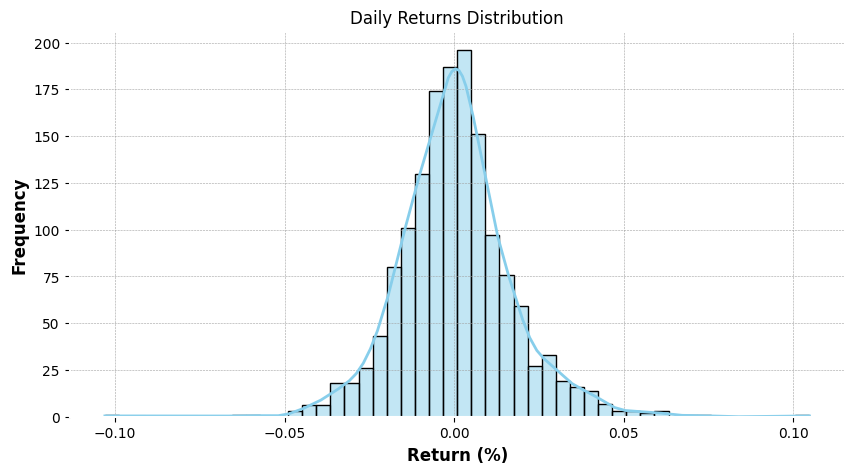

In [541]:
plt.figure(figsize=(10, 5))
sns.histplot(ss_pd['Return'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Daily Returns Distribution')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

##### Trend Analysis

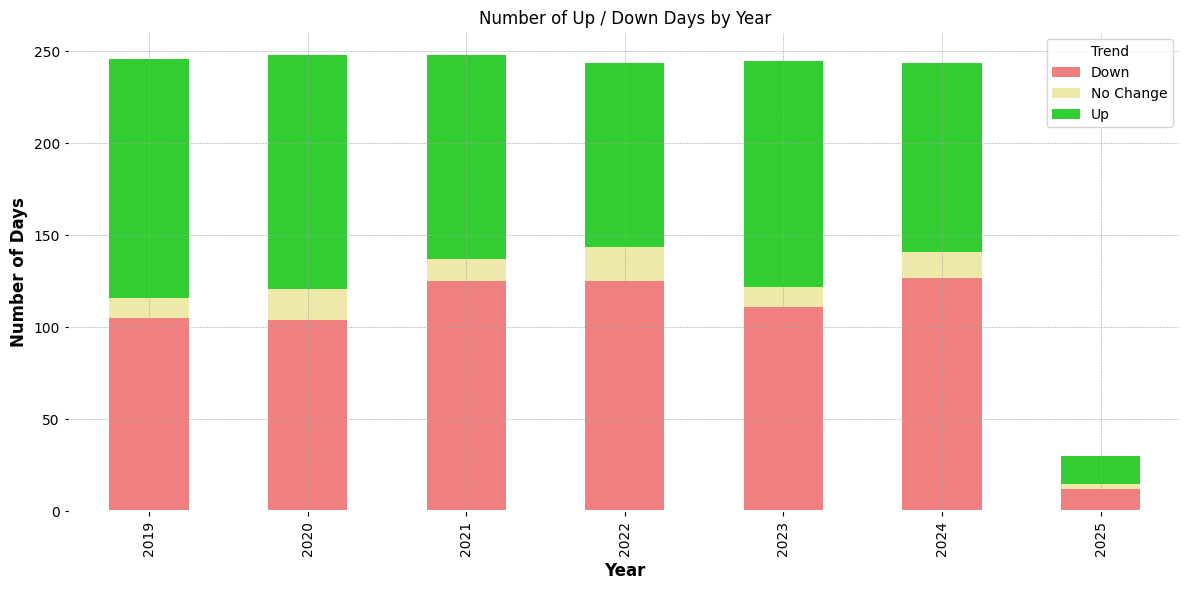

In [542]:
# Label the trend
ss_pd['Trend'] = np.where(ss_pd['Return'] > 0, 'Up', 
                       np.where(ss_pd['Return'] < 0, 'Down', 'No Change'))

ss_pd['Year'] = ss_pd['Date'].dt.year
trend_by_year = ss_pd.groupby(['Year', 'Trend']).size().unstack(fill_value=0)

colors = {
    'Up': 'limegreen',
    'Down': 'lightcoral',
    'No Change': 'palegoldenrod'
}
trend_by_year.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in trend_by_year.columns])
plt.title('Number of Up / Down Days by Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend(title='Trend')
plt.tight_layout()
plt.show()

##### Stock Price & Trading Volume with SMA (20/50)

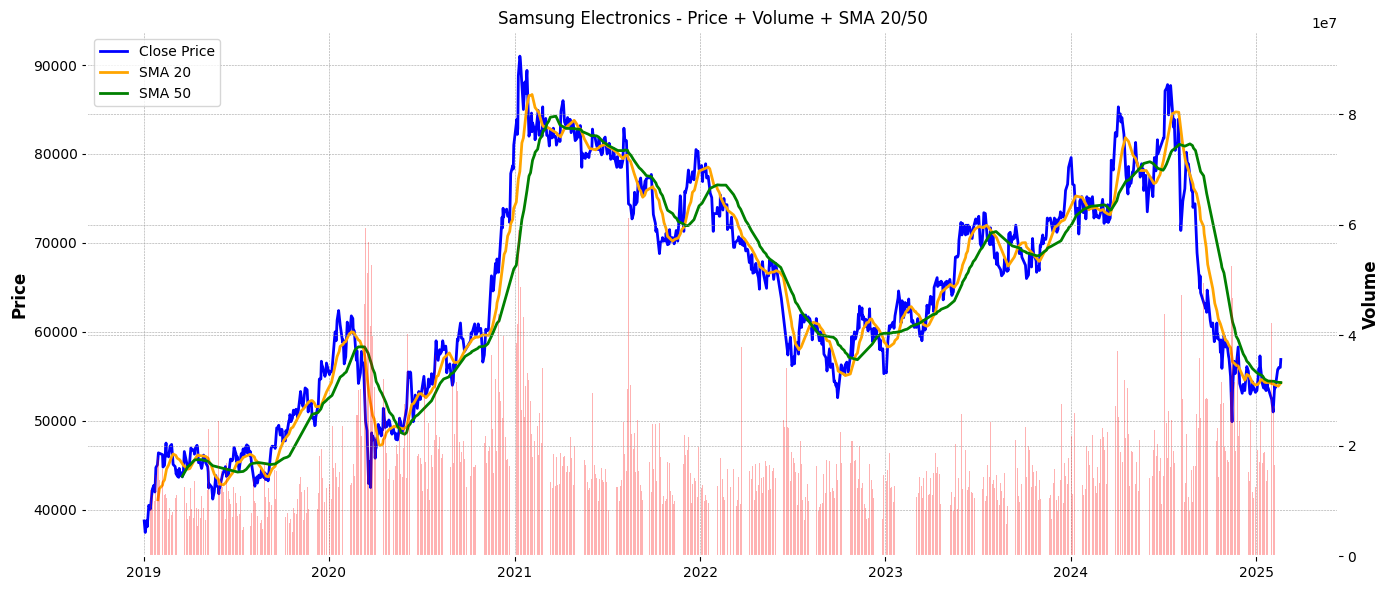

In [543]:
# Đọc dữ liệu
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)

# Tính SMA 20 và SMA 50
ss_pd['SMA20'] = ss_pd['Close'].rolling(window=20).mean()
ss_pd['SMA50'] = ss_pd['Close'].rolling(window=50).mean()

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(ss_pd['Date'], ss_pd['Close'], label='Close Price', color='blue')
ax1.plot(ss_pd['Date'], ss_pd['SMA20'], label='SMA 20', color='orange')
ax1.plot(ss_pd['Date'], ss_pd['SMA50'], label='SMA 50', color='green')
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')

# Vẽ biểu đồ Volume
ax2 = ax1.twinx()
ax2.bar(ss_pd['Date'], ss_pd['Volume'], color='red', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y')

# Định dạng thời gian
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Samsung Electronics - Price + Volume + SMA 20/50')
ax1.legend(loc='upper left')
fig.tight_layout()
plt.show()


##### Trading Volume with VMA (20/50)

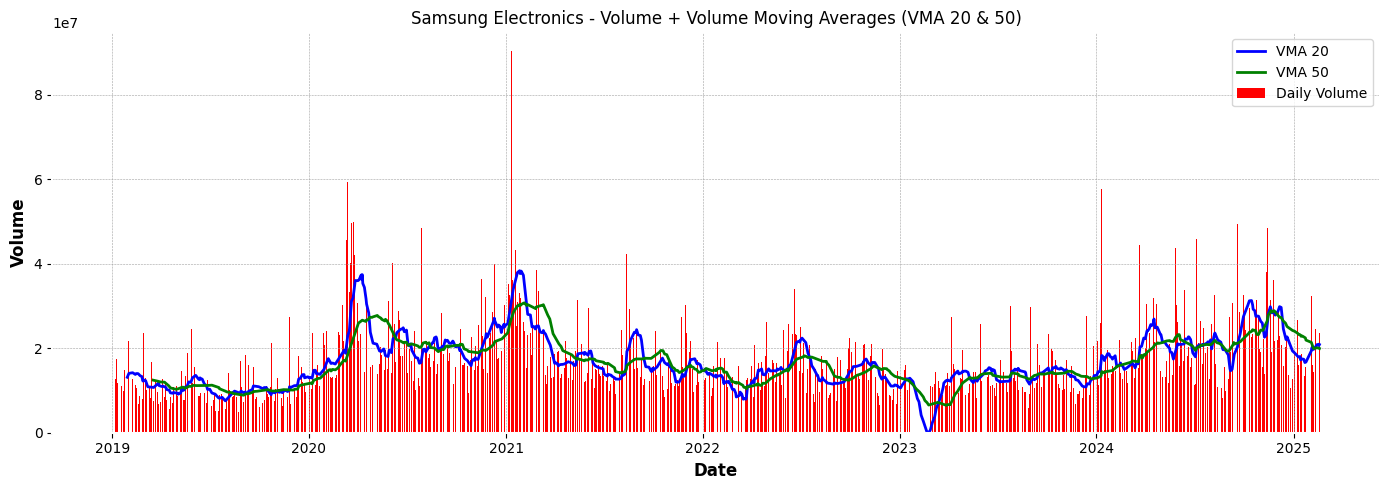

In [544]:
# Đọc dữ liệu
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)

# Tính SMA cho Volume (VMA)
ss_pd['VMA20'] = ss_pd['Volume'].rolling(window=20).mean()
ss_pd['VMA50'] = ss_pd['Volume'].rolling(window=50).mean()

# Vẽ biểu đồ Volume + VMA
plt.figure(figsize=(14, 5))
plt.bar(ss_pd['Date'], ss_pd['Volume'], color='red', label='Daily Volume')
plt.plot(ss_pd['Date'], ss_pd['VMA20'], color='blue', label='VMA 20')
plt.plot(ss_pd['Date'], ss_pd['VMA50'], color='green', label='VMA 50')

plt.title("Samsung Electronics - Volume + Volume Moving Averages (VMA 20 & 50)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

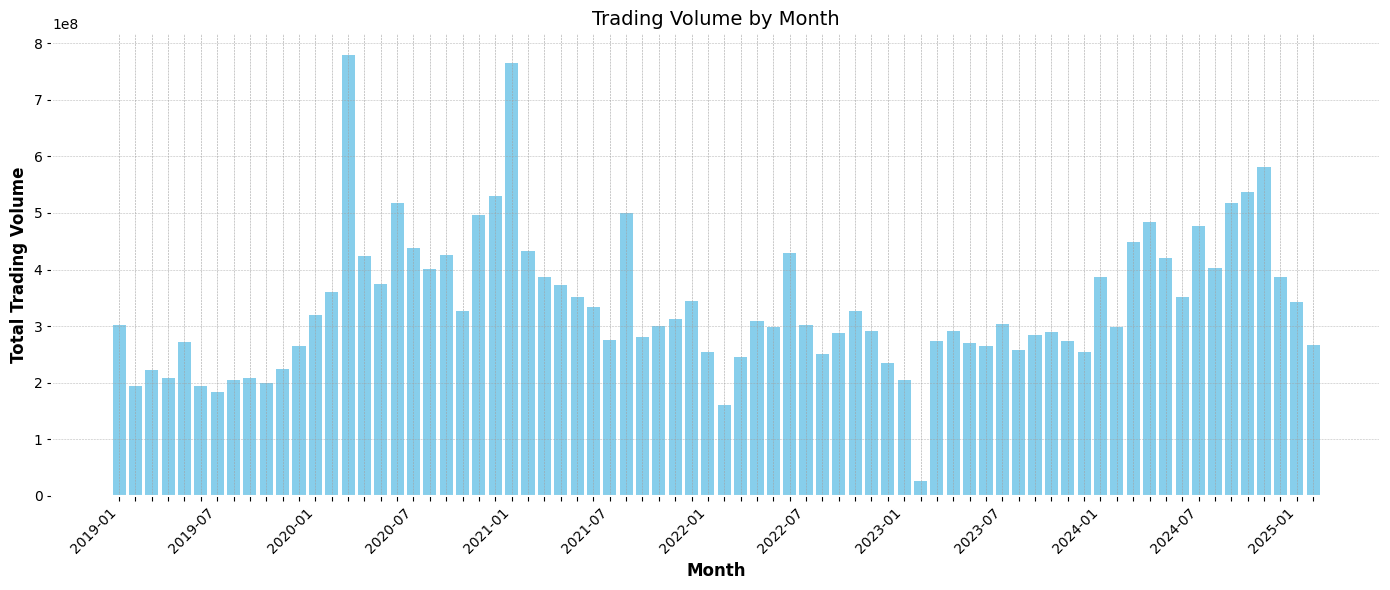

In [545]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])

ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month

monthly_volume = ss_pd.groupby(['Year', 'Month'])['Volume'].sum().reset_index()

monthly_volume['Year-Month'] = monthly_volume['Year'].astype(str) + "-" + monthly_volume['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
plt.bar(monthly_volume['Year-Month'], monthly_volume['Volume'], color='skyblue')

xticks = monthly_volume['Year-Month']
xtick_labels = [label if i % 6 == 0 else '' for i, label in enumerate(xticks)]
plt.xticks(ticks=range(len(xticks)), labels=xtick_labels, rotation=45, ha='right')

plt.title('Trading Volume by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Trading Volume', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


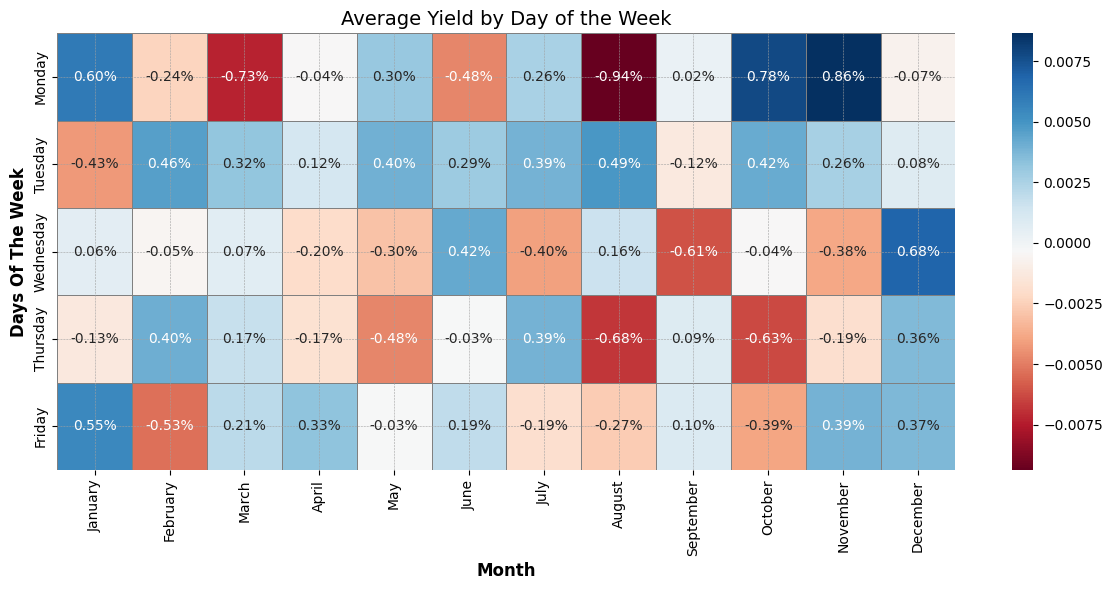

In [546]:

ss_pd = ss_pd.sort_values('Date')
ss_pd['Return'] = ss_pd['Close'].pct_change()
ss_pd['Weekday'] = ss_pd['Date'].dt.day_name()
ss_pd['Month'] = ss_pd['Date'].dt.month_name()

pivot_table = ss_pd.pivot_table(index='Weekday', columns='Month', values='Return', aggfunc='mean')

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

pivot_table = pivot_table.reindex(index=weekday_order, columns=month_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='RdBu', annot=True, fmt=".2%", linewidths=0.5, linecolor='gray')
plt.title('Average Yield by Day of the Week', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Days Of The Week')
plt.tight_layout()
plt.show()


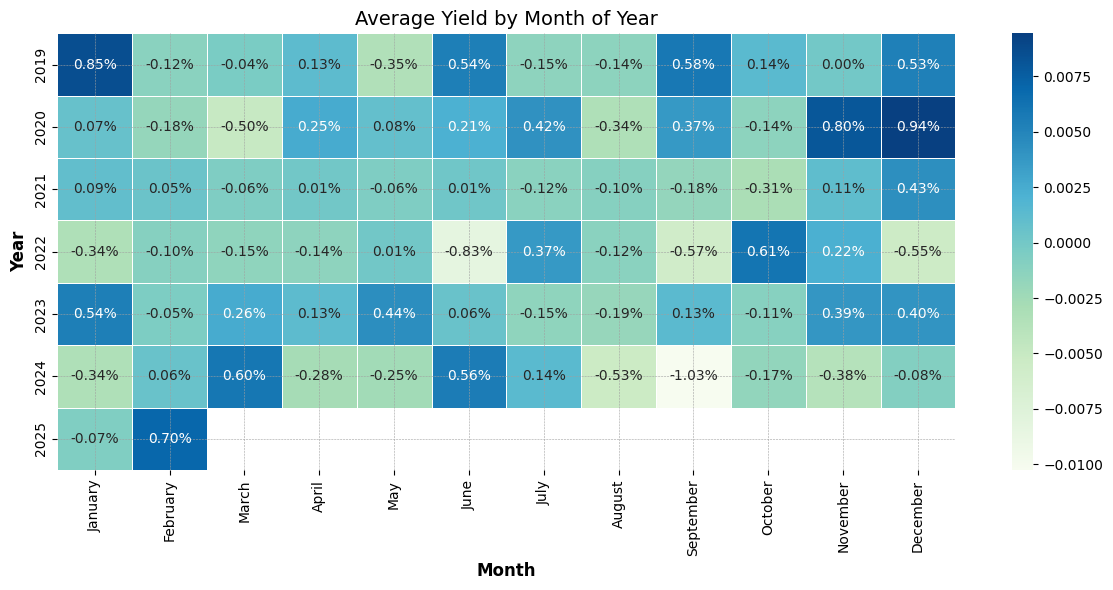

In [547]:
ss_pd = pd.read_csv("Samsung Electronics Stock Historical Price.csv")
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd = ss_pd.sort_values('Date')

ss_pd['Return'] = ss_pd['Close'].pct_change()

ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month_name()

pivot = ss_pd.pivot_table(index='Year', columns='Month', values='Return', aggfunc='mean')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot = pivot[month_order]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='GnBu', annot=True, fmt=".2%", linewidths=0.5)
plt.title('Average Yield by Month of Year', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


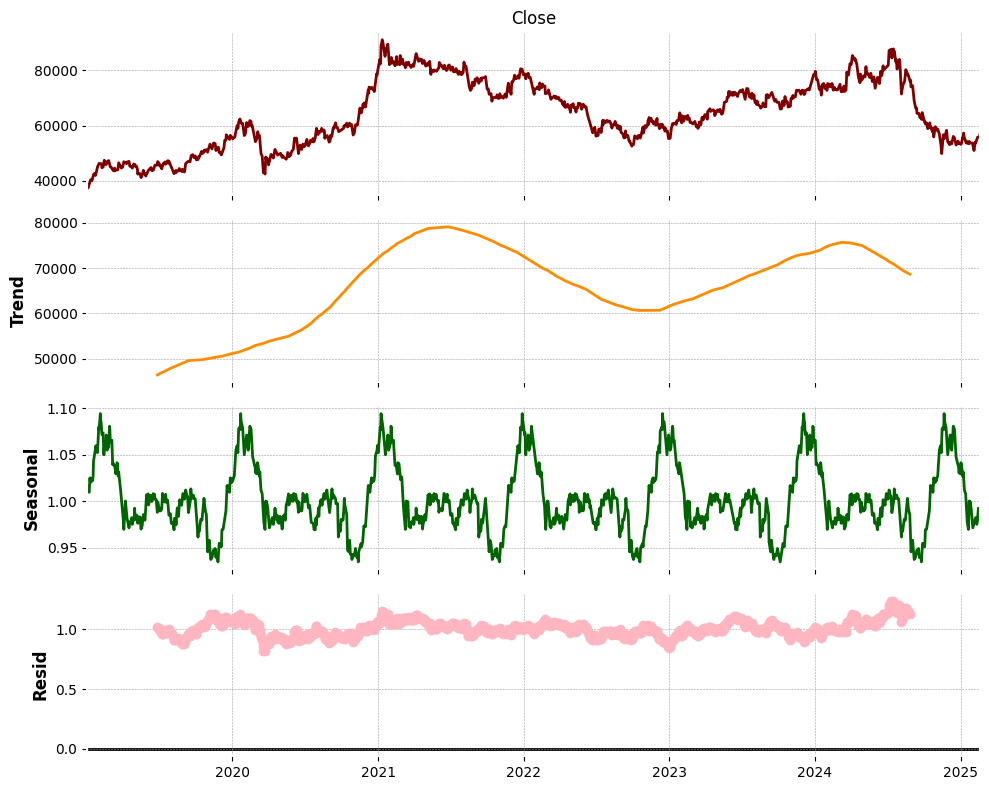

In [548]:
file_path = "Samsung Electronics Stock Historical Price.csv"
ss_pd = pd.read_csv(file_path)
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)
ss_pd.set_index('Date', inplace=True)

close_series = ss_pd['Close'].asfreq('B').ffill()

decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

fig = decomposition.plot()
fig.set_size_inches(10, 8)

axes = fig.axes

axes[0].lines[0].set_color('maroon')      
axes[1].lines[0].set_color('darkorange')       
axes[2].lines[0].set_color('darkgreen')     
axes[3].lines[0].set_color('lightpink')       

plt.tight_layout()

# **3. TECHNICAL ANALYSIS**

## **3.1. MACD & TRADE SIGNALS:**

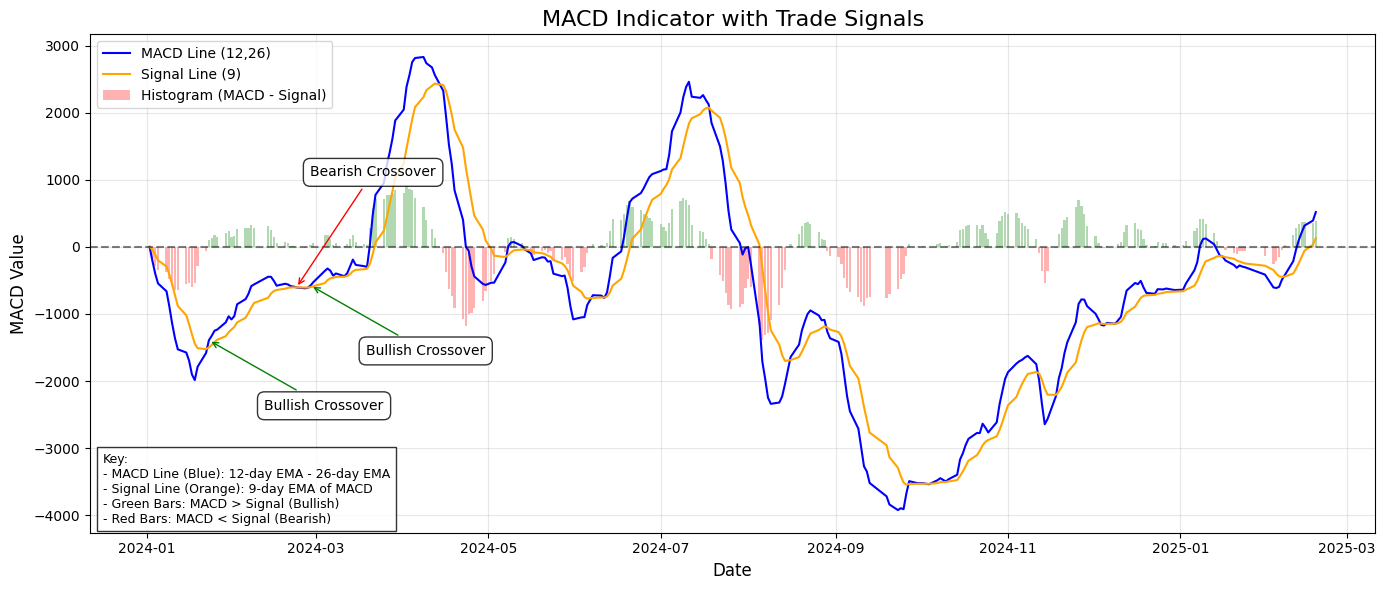

In [10]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd = ss_pd[ss_pd['Date'] > datetime(2023, 12, 31)]

#Calculate MACD 
def calculate_macd(ss_pd, fast=12, slow=26, signal=9):
    ss_pd['EMA_Fast'] = ss_pd['Close'].ewm(span=fast, adjust=False).mean()
    ss_pd['EMA_Slow'] = ss_pd['Close'].ewm(span=slow, adjust=False).mean()
    ss_pd['MACD'] = ss_pd['EMA_Fast'] - ss_pd['EMA_Slow']
    ss_pd['Signal_Line'] = ss_pd['MACD'].ewm(span=signal, adjust=False).mean()
    ss_pd['MACD_Histogram'] = ss_pd['MACD'] - ss_pd['Signal_Line']
    return ss_pd

ss_pd = calculate_macd(ss_pd)

#Plot MACD with Annotations 
plt.figure(figsize=(14, 6))

#MACD and Signal Line
plt.plot(ss_pd['Date'], ss_pd['MACD'], label='MACD Line (12,26)', color='blue', linewidth=1.5)
plt.plot(ss_pd['Date'], ss_pd['Signal_Line'], label='Signal Line (9)', color='orange', linewidth=1.5)

#Histogram (Green/Red Bars)
plt.bar(ss_pd['Date'], ss_pd['MACD_Histogram'],
        color=np.where(ss_pd['MACD_Histogram'] > 0, 'green', 'red'),
        alpha=0.3, label='Histogram (MACD - Signal)')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Zero line

#Annotations
crossovers = ss_pd[ss_pd['MACD_Histogram'].shift(1) * ss_pd['MACD_Histogram'] < 0]
for i, date in enumerate(crossovers['Date'][:3]):  # Show first 3 crossovers
    if ss_pd.loc[ss_pd['Date'] == date, 'MACD_Histogram'].values[0] > 0:  # Bullish crossover
        plt.annotate('Bullish Crossover',
                     xy=(date, ss_pd.loc[ss_pd['Date'] == date, 'MACD'].values[0]),
                     xytext=(40, -50), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='green'),
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    else:  # Bearish crossover
        plt.annotate('Bearish Crossover',
                     xy=(date, ss_pd.loc[ss_pd['Date'] == date, 'MACD'].values[0]),
                     xytext=(10, 80), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='red'),
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

#General Explanations
plt.text(
    0.01, 0.02,
    'Key:\n'
    '- MACD Line (Blue): 12-day EMA - 26-day EMA\n'
    '- Signal Line (Orange): 9-day EMA of MACD\n'
    '- Green Bars: MACD > Signal (Bullish)\n'
    '- Red Bars: MACD < Signal (Bearish)',
    transform=plt.gca().transAxes,
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8)
)

#Formatting
plt.title('MACD Indicator with Trade Signals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **3.2. RELATIVE STRENGTH INDEX :**

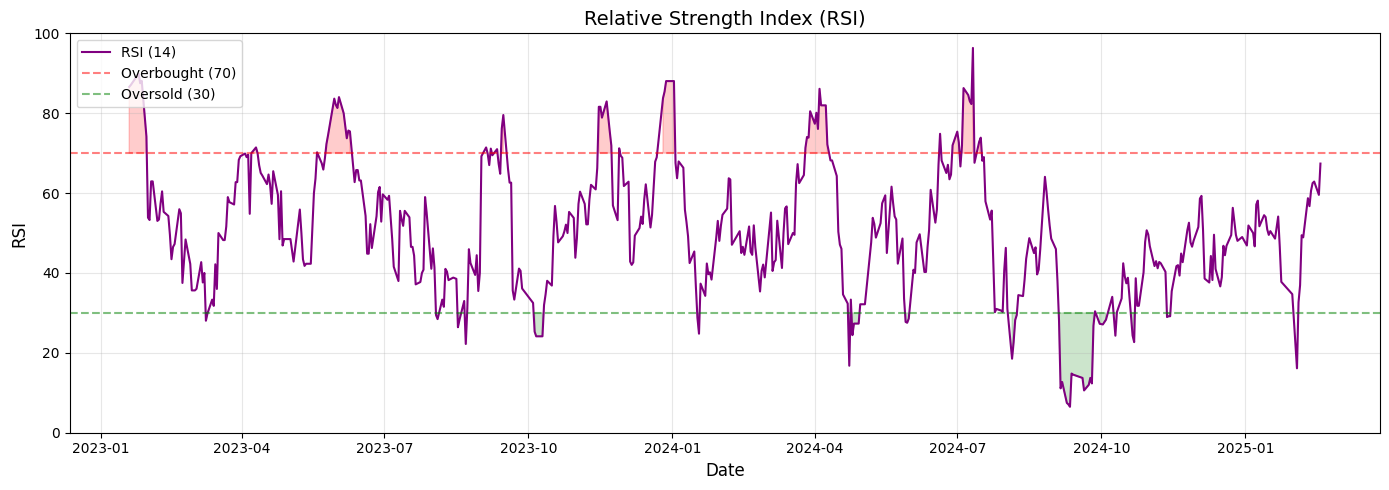

In [9]:
ss_pd = ss_pd[~((ss_pd['Date'] >= '2022-01-01') & (ss_pd['Date'] <= '2022-12-31'))]

# Calculate RSI  
def calculate_rsi(ss_pd, window=14):
    delta = ss_pd['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

ss_pd['RSI'] = calculate_rsi(ss_pd)  # Add RSI column

# Chart: RSI  
plt.figure(figsize=(14, 5))

# Plot RSI
plt.plot(ss_pd['Date'], ss_pd['RSI'], label='RSI (14)', color='purple', linewidth=1.5)
plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
plt.fill_between(ss_pd['Date'], 70, ss_pd['RSI'].where(ss_pd['RSI'] >= 70), 
                 color='red', alpha=0.2)
plt.fill_between(ss_pd['Date'], 30, ss_pd['RSI'].where(ss_pd['RSI'] <= 30), 
                 color='green', alpha=0.2)

# Formatting
plt.title('Relative Strength Index (RSI)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)  # RSI ranges from 0 to 100
plt.tight_layout()
plt.show()


## **3.3. EXPONENTIAL MOVING AVERAGE:**

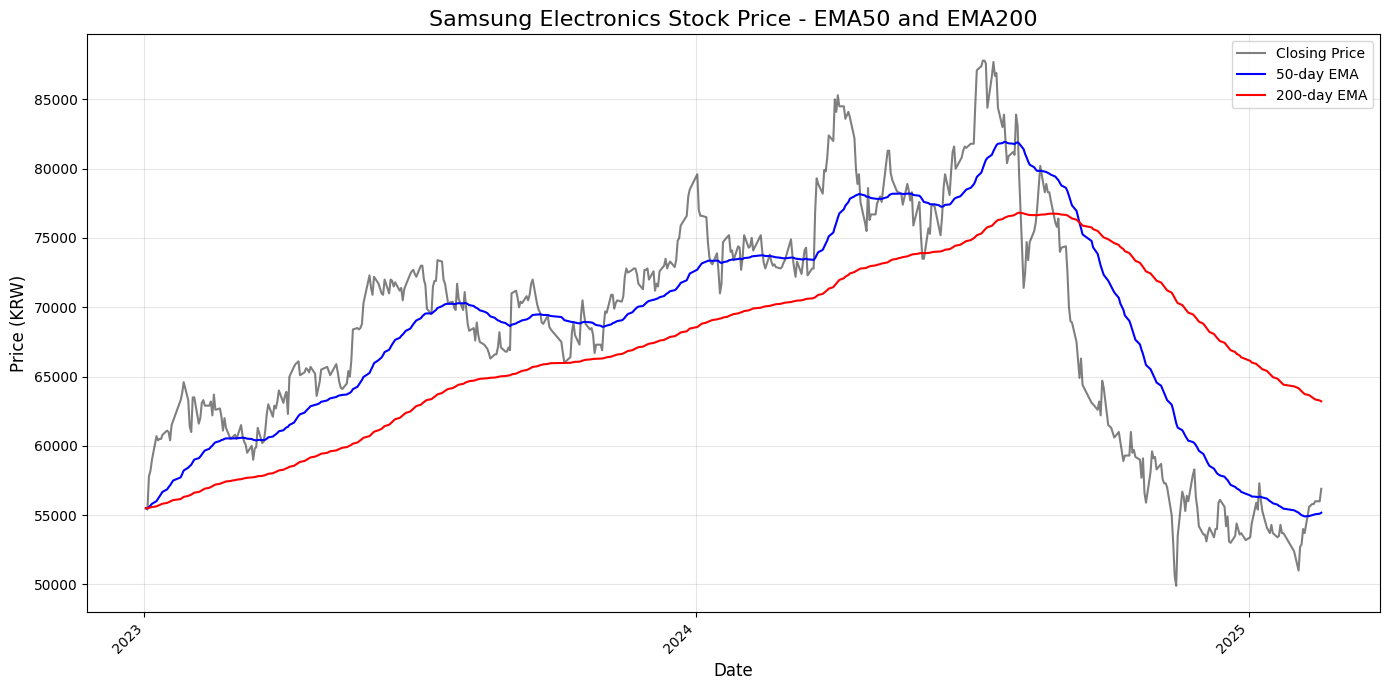

In [ ]:
ss_pd = ss_pd.sort_values('Date')  # Ensure data is in chronological order

# Calculate EMAs
ss_pd['EMA50'] = ss_pd['Close'].ewm(span=50, adjust=False).mean()
ss_pd['EMA200'] = ss_pd['Close'].ewm(span=200, adjust=False).mean()

# Ensure 'Date' is datetime before extracting .date
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd['Date'] = ss_pd['Date'].dt.date

# Filter data - remove 2019-2022
start_date = date(2022, 1, 1)
ss_pd = ss_pd[ss_pd['Date'] > start_date]

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(ss_pd['Date'], ss_pd['Close'], label='Closing Price', color='black', alpha=0.5)
plt.plot(ss_pd['Date'], ss_pd['EMA50'], label='50-day EMA', color='blue')
plt.plot(ss_pd['Date'], ss_pd['EMA200'], label='200-day EMA', color='red')

# Formatting
plt.title('Samsung Electronics Stock Price - EMA50 and EMA200', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Simplified x-axis formatting - only years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Remove minor ticks (months)
ax.xaxis.set_minor_locator(plt.NullLocator())

# Rotate and align the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## **3.4. BOLLINGER BANDS:**

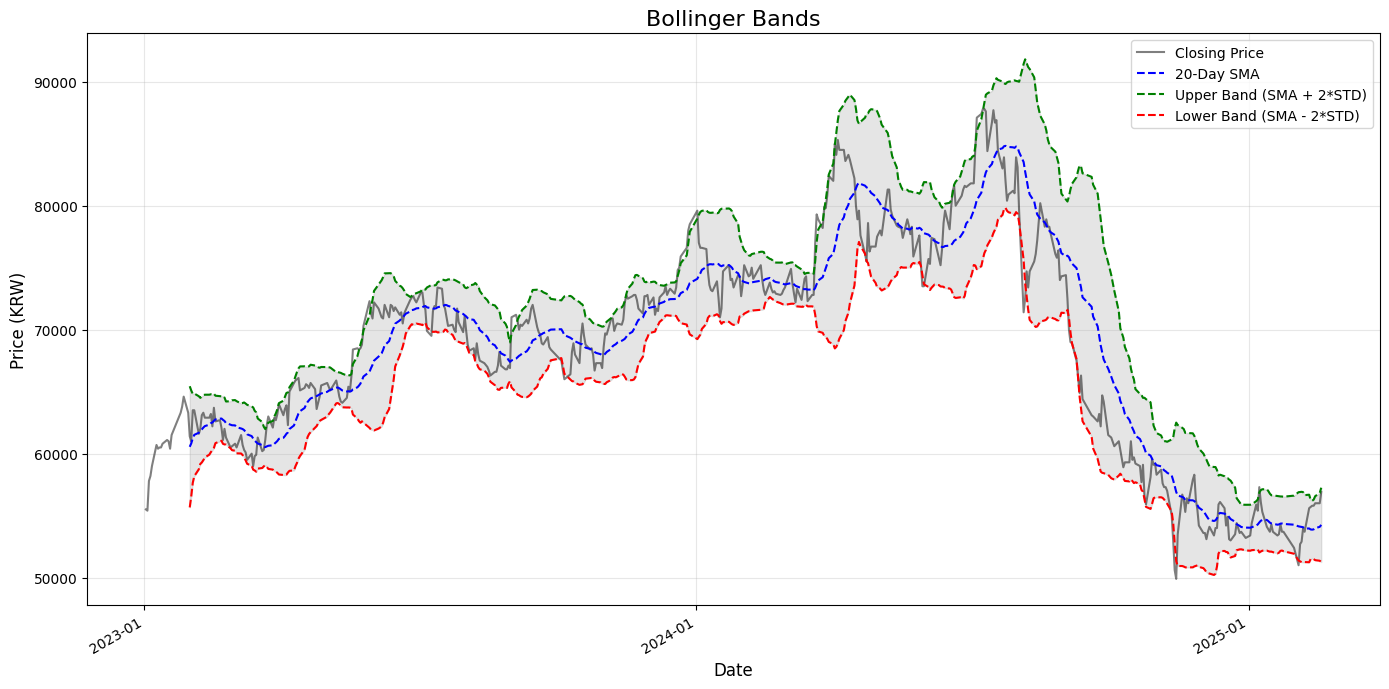

In [40]:
ss_pd = ss_pd.sort_values('Date')  # Ensure data is in chronological order

from datetime import datetime

# Filter data for 2023 to 2025
start = datetime(2023, 1, 1).date()
end = datetime(2025, 12, 31).date()
ss_pd = ss_pd[(ss_pd['Date'] >= start) & (ss_pd['Date'] <= end)]

# Calculate Bollinger Bands
window = 20  # Moving average window
ss_pd['SMA'] = ss_pd['Close'].rolling(window=window).mean()  # Simple Moving Average
ss_pd['STD'] = ss_pd['Close'].rolling(window=window).std()   # Standard Deviation
ss_pd['Upper Band'] = ss_pd['SMA'] + (2 * ss_pd['STD'])      # Upper Band
ss_pd['Lower Band'] = ss_pd['SMA'] - (2 * ss_pd['STD'])      # Lower Band

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(ss_pd['Date'], ss_pd['Close'], label='Closing Price', color='black', alpha=0.5)
plt.plot(ss_pd['Date'], ss_pd['SMA'], label='20-Day SMA', color='blue', linestyle='--')
plt.plot(ss_pd['Date'], ss_pd['Upper Band'], label='Upper Band (SMA + 2*STD)', color='green', linestyle='--')
plt.plot(ss_pd['Date'], ss_pd['Lower Band'], label='Lower Band (SMA - 2*STD)', color='red', linestyle='--')

# Fill the area between the bands
plt.fill_between(ss_pd['Date'], ss_pd['Upper Band'], ss_pd['Lower Band'], color='gray', alpha=0.2)

# Formatting
plt.title('Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotate x-axis labels

plt.tight_layout()
plt.show()


## **3.5. ON BALANCE VOLUME:**

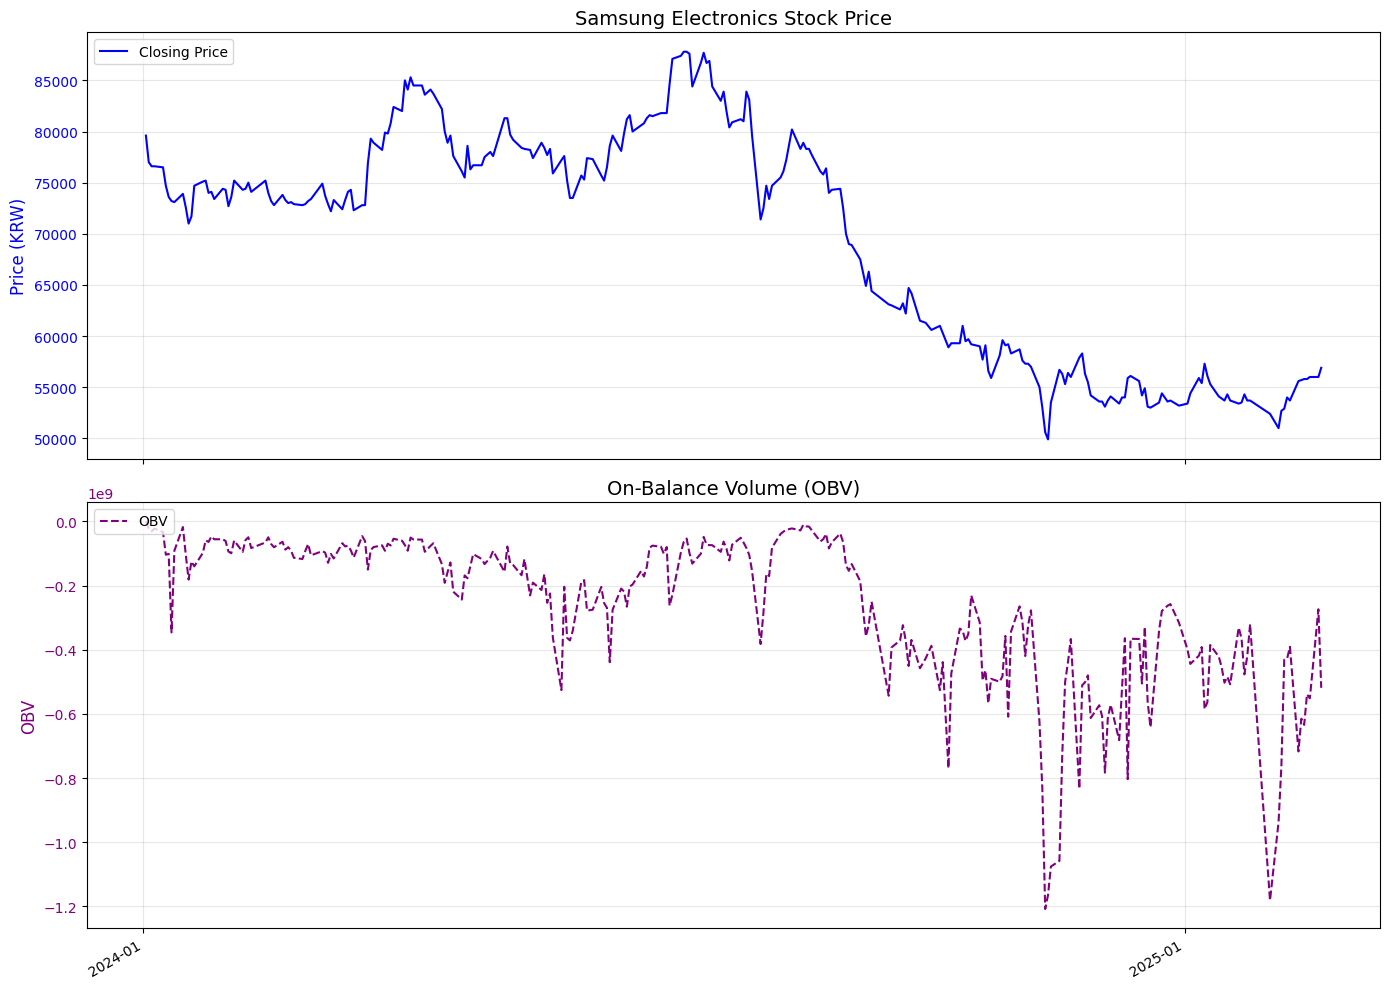

In [42]:
ss_pd = ss_pd.sort_values('Date')  # Ensure data is in chronological order

# Filter data for 2024 to 2025
from datetime import datetime

start_filter = datetime(2024, 1, 1).date()
end_filter = datetime(2025, 12, 31).date()
ss_pd = ss_pd[(ss_pd['Date'] >= start_filter) & (ss_pd['Date'] <= end_filter)]

# Calculate OBV
ss_pd['OBV'] = 0  # Initialize OBV column
ss_pd['OBV'] = ss_pd['OBV'].astype(float)  # Ensure OBV is float for cumulative sum
ss_pd['OBV'] = ss_pd['Volume'] * (ss_pd['Close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))).cumsum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot stock price on the first subplot
ax1.plot(ss_pd['Date'], ss_pd['Close'], label='Closing Price', color='blue', linewidth=1.5)
ax1.set_ylabel('Price (KRW)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Samsung Electronics Stock Price', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot OBV on the second subplot
ax2.plot(ss_pd['Date'], ss_pd['OBV'], label='OBV', color='purple', linewidth=1.5, linestyle='--')
ax2.set_ylabel('OBV', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_title('On-Balance Volume (OBV)', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format x-axis to show months
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotate x-axis labels

plt.tight_layout()
plt.show()

# **4. FUTURE FORCASTING**

## **4.1. Rolling Mean & Standard Deviation:**

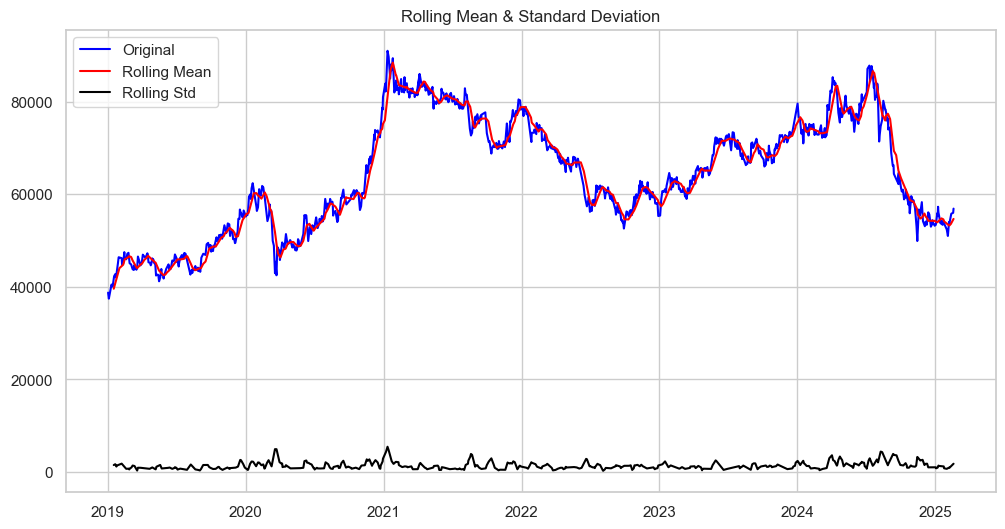

In [529]:
def test_stationarity(time_series):
    # Calculate rolling statistics
    rolling_mean = ss_pd['Close'].rolling(window=12).mean()
    rolling_std = ss_pd['Close'].rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(ss_pd['Close'], color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)

test_stationarity(ss_pd['Close'])

## **4.2. XGBoost model:**
The stock's daily closing price:

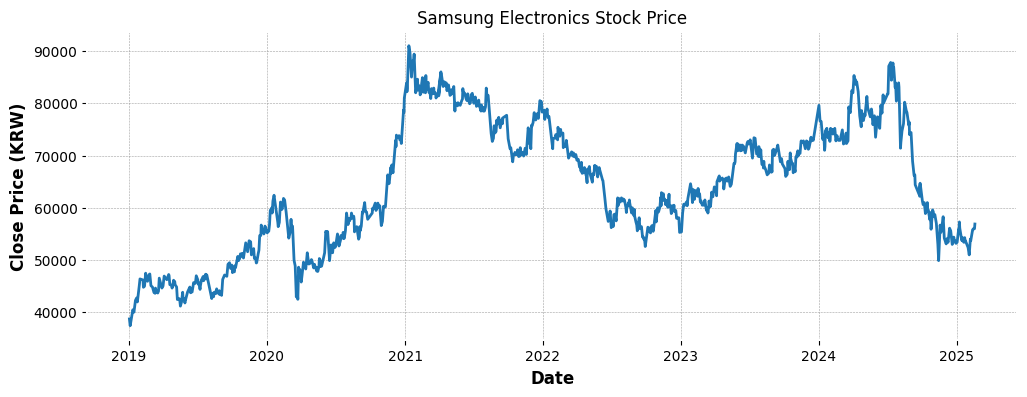

In [550]:
plt.figure(figsize=(12, 4))
plt.plot(ss_pd['Close'])
plt.title('Samsung Electronics Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.grid(True)
plt.show()

In [551]:
df_simple = ss_pd.reset_index()[['Date', 'Close']].copy()

# Display the first few rows
print("Simple dataframe with Date and Close columns:")
print(df_simple.head())

Simple dataframe with Date and Close columns:
        Date    Close
0 2019-01-02  38750.0
1 2019-01-03  37600.0
2 2019-01-04  37450.0
3 2019-01-07  38750.0
4 2019-01-08  38100.0


In [552]:
df_simple['Date'] = pd.to_datetime(df_simple['Date'])
df_simple = df_simple.sort_values("Date").reset_index(drop=True)
df_simple = df_simple.rename(columns={"Date": "ds", "Close": "y"})

In [553]:
# Create lag features
for lag in range(1, 8):
    df_simple[f'lag_{lag}'] = df_simple['y'].shift(lag)

df_simple.dropna(inplace=True)

# Features and target
X = df_simple[[f'lag_{i}' for i in range(1, 8)]]
y = df_simple['y']

# Train/test split
train_size = int(len(df_simple) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
model = XGBRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [554]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 1147.04, RMSE: 1537.06, MAPE: 1.65%


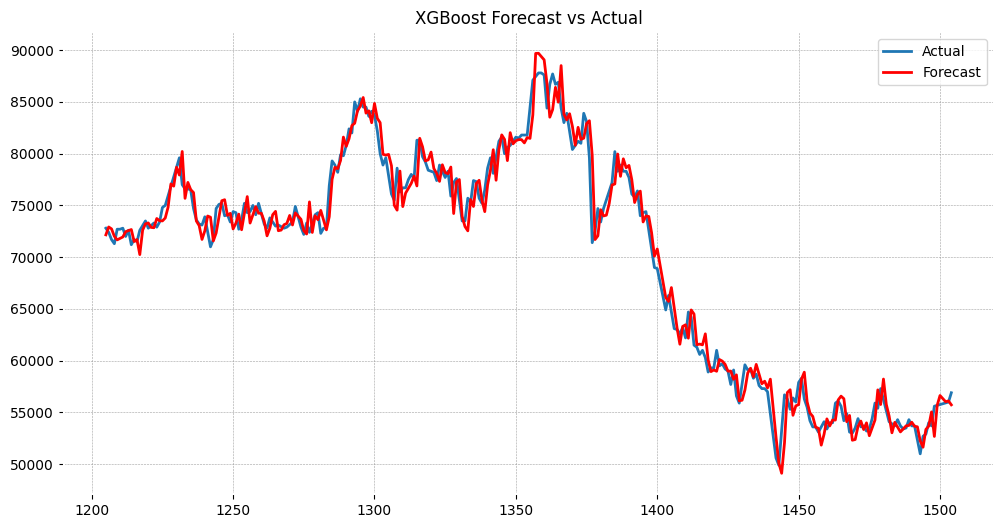

In [555]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.grid(True)
plt.show()

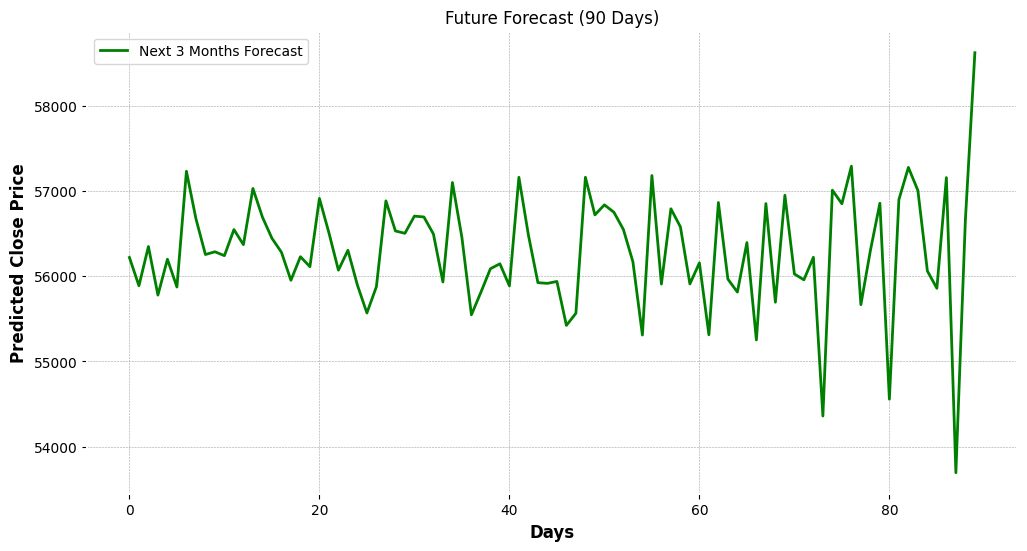

In [556]:
# Forecast next 3 months (assume 90 business days)
future = df_simple.iloc[-7:][['y']].values.flatten().tolist()
forecast = []

for _ in range(90):
    X_next = np.array(future[-7:]).reshape(1, -1)
    next_pred = model.predict(X_next)[0]
    forecast.append(next_pred)
    future.append(next_pred)

# Plot 3-month forecast
plt.figure(figsize=(12,6))
plt.plot(range(90), forecast, label="Next 3 Months Forecast", color='green')
plt.title("Future Forecast (90 Days)")
plt.xlabel("Days")
plt.ylabel("Predicted Close Price")
plt.grid(True)
plt.legend()


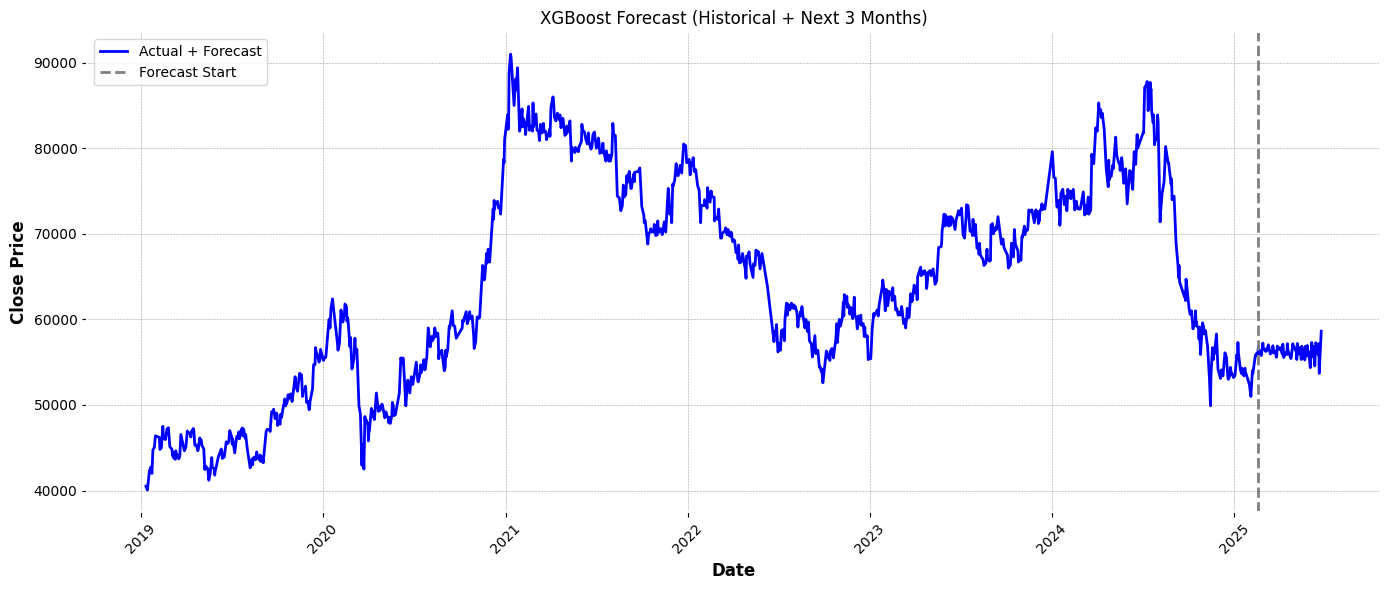

In [558]:
# Create date array for forecast
last_date = df_simple['ds'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

  # B = business days

historical_df = df_simple[['ds', 'y']].copy()
forecast_df = pd.DataFrame({
    'ds': forecast_dates[:len(forecast)],
    'y': forecast
})

combined_df = pd.concat([historical_df, forecast_df]).reset_index(drop=True)

# Plot combination
plt.figure(figsize=(14, 6))
plt.plot(combined_df['ds'], combined_df['y'], label='Actual + Forecast', color='blue')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("XGBoost Forecast (Historical + Next 3 Months)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
